In [11]:
import math
from collections import defaultdict
from tabulate import tabulate

def ranked_vote_verbose(user_preferences):

    def print_standings(round_number, focus_books=None):
        
        focus_books = focus_books or []
        
        print(f"Round {round_number}:")
        if focus_books:
            print(f"  Focus on: {', '.join(focus_books)}")

        for book, counts in sorted(vote_table.items(), key=lambda x: x[1][3], reverse=True):
            print(f"  {book}: {counts[3]} win counters")
        
        print("")  # Add an empty line for better readability

    def print_votetable(votetable):

        table = [(book, counts[0], counts[1], counts[2], counts[3]) for book, counts in votetable.items()]
        print("VOTE TABLE:")
        print(tabulate(table, headers=["Book", "First Choice", "Second Choice", "Third Choice", "Win Counters"]))
        
        print("")  # Add an empty line for better readability

    def elim_books_complex(vote_table):

        # Put books with the lowest number of win_counters and min vote counts in candidates to eliminate
        min_win_counter = min(counts[3] for counts in vote_table.values())
        print(f"Min Win Counters: {min_win_counter}")
        
        # Get the lowest sum of all votes
        min_vote_counts = min(sum(counts[:3]) for counts in vote_table.values())
        print(f"Min Vote Counts: {min_vote_counts}")

        # Get the candidates to eliminate with the lowest win counters and the lowest vote counts
        candidates_to_eliminate = [(book, counts) for book, counts in vote_table.items() if counts[3] == min_win_counter and sum(counts[:3]) == min_vote_counts]
        print(f"Candidates to Eliminate: {candidates_to_eliminate}")

        # Get the highest sum of weighted book vote counts
        max_wbv_sum = max((counts[0]*1 + counts[1]*2 + counts[2]*3) for books, counts in candidates_to_eliminate)
        print(f"Maximum Weighted Book Vote Sum: {max_wbv_sum}")

        # Choose your next books to eliminate by picking the candidates to eliminate with the highest weighted book vote sums
        books_to_eliminate = [book for book, counts in candidates_to_eliminate if (counts[0]*1 + counts[1]*2 + counts[2]*3) == max_wbv_sum]
        print(f"Books to Eliminate: {books_to_eliminate} \n")

        return books_to_eliminate

    # Eliminates books just by weighting the 1st, 2nd, and 3rd place votes they have
    # --- ISSUE, DON'T ACCOUNT FOR TIES
    def elim_books_simple(vote_table):

        # Choose the book(s) to eliminate based on the minimum weighted book vote sum
        books_to_eliminate = min(vote_table.items(), key=lambda item: (item[1][0]*3 + item[1][1]*2 + item[1][2]*1))
        print(f"Book to Eliminate: {books_to_eliminate[0]}\n")

        return [books_to_eliminate[0]]

    # Eliminates books based on the instant-runoff voting method
    def elim_books_irv(vote_table):
        # Choose the books to eliminate based on who has the lowest number of first place votes (item[1][0] = first place votes)
        books_to_eliminate = min(vote_table.items(), key=lambda item: item[1][0])

        return [books_to_eliminate[0]]


    # Calculate the vote threshold
    threshold = math.ceil(len(user_preferences) / 2)

    # Create a vote table
    vote_table = defaultdict(lambda: [0, 0, 0, 0])  # First 3 positions for votes, 4th for win_counter

    # Count initial votes
    for prefs in user_preferences.values():
        for i, book in enumerate(prefs[:3]):
            vote_table[book][i] += 1

    # Update win_counter
    for book in list(vote_table):
        vote_table[book][3] = vote_table[book][0]  # Set win_counter

    round_number = 0  # To keep track of rounds
    print_votetable(vote_table) # Initial vote table
    print_standings(round_number)  # Initial standings
    
    # Remove books with 0 win counters from the start
    vote_table = {book: counts for book, counts in vote_table.items() if counts[3] > 0}
    user_preferences = {user: [pref for pref in prefs if pref in vote_table] for user, prefs in user_preferences.items()}
    
    round_number += 1  # Iterate one round after removing 0 win-counter books
    print_standings(round_number)  # Initial standings

    while True:
        # Check for a winner
        for book, counts in vote_table.items():
            if counts[3] >= threshold:
                print(f"Winner found: {book} with {counts[3]} win counter(s)")
                return book

        # Find books with the lowest win_counters and prepare for elimination
        if not vote_table:
            print("No winner could be determined with the given preferences.")
            return None

        # Run elim_books to get candidates to eliminate
        books_to_eliminate = elim_books_irv(vote_table)

        # NEED TO RECOMMENT BELOW, CONFUSING
        # Reallocation of votes for users whose active vote is on an eliminated book
        for user, prefs in user_preferences.items():
            if prefs[0] in books_to_eliminate:
                prefs.pop(0)  # Remove the eliminated book from preferences
                if prefs:  # If there are still preferences left
                    new_vote = prefs[0]
                    vote_table[new_vote][3] += 1  # Increase win counter for the next preference
                else:
                    continue  # No more preferences left for this user

        # Eliminate candidates and update the vote_table
        for book in books_to_eliminate:
            print(vote_table[book])
            del vote_table[book]

        round_number += 1
        print_standings(round_number, focus_books=books_to_eliminate)

# Example usage with the same user preferences
user_preferences = {
    "user1": ["Book A", "Book D", "Book F"],
    "user2": ["Book B", "Book E", "Book A"],
    "user3": ["Book C", "Book F", "Book D"],
    "user4": ["Book D", "Book A", "Book B"],
    "user5": ["Book E", "Book B", "Book C"],
}


ranked_vote_verbose(user_preferences)

VOTE TABLE:
Book      First Choice    Second Choice    Third Choice    Win Counters
------  --------------  ---------------  --------------  --------------
Book A               1                1               1               1
Book D               1                1               1               1
Book F               0                1               1               0
Book B               1                1               1               1
Book E               1                1               0               1
Book C               1                0               1               1

Round 0:
  Book A: 1 win counters
  Book D: 1 win counters
  Book B: 1 win counters
  Book E: 1 win counters
  Book C: 1 win counters
  Book F: 0 win counters

Round 1:
  Book A: 1 win counters
  Book D: 1 win counters
  Book B: 1 win counters
  Book E: 1 win counters
  Book C: 1 win counters

[1, 1, 1, 1]
Round 2:
  Focus on: Book A
  Book D: 2 win counters
  Book B: 1 win counters
  Book E: 1 win counters


KeyError: 'Book A'

Realized I made something faaar too complicated because I was basing it off my understanding of the paper calculations and not the actual IRV voting system. Leaving the old code in the notebook entry above, but stripping it down to go from scratch below.

In [2]:
from collections import Counter
from collections import defaultdict

def instant_runoff_vote(user_prefs):
    
    # Defines a function that prints the current standings from our vote counts
    def print_standings(first_vote_counts):

        # Print the standings
        for book, vote in first_vote_counts.items():
            print(f"{book}: {vote} votes")

        # Add line break to space things out
        print("")

        return
    
    # Defines a function that gets the list of the books with the max votes, 
    # returns that and the max vote count
    def most_votes(vote_counts, eliminated_books):

        # A count of the votes for each book, excluding eliminated books
        non_elimed_vote_counts = {book: count for book, count in vote_counts.items() if book not in eliminated_books}

        # Find the maximum vote count
        max_votes = max(non_elimed_vote_counts.values(), default=0)
        
        # Get all books that have this maximum count
        most_voted_books = [book for book, count in non_elimed_vote_counts.items() if count == max_votes]
        
        return most_voted_books, max_votes
    
    # Defines a function that gets the list of the books with the minimum votes, 
    # returns that and the minimum vote count
    def least_votes(vote_counts, eliminated_books):

        # A count of the votes for each book, excluding eliminated books
        non_elimed_vote_counts = {book: count for book, count in vote_counts.items() if book not in eliminated_books}

        # Find the minimum vote count
        min_votes = min(non_elimed_vote_counts.values(), default=0)
        
        # Get all books that have this minimum count
        least_voted_books = [book for book, count in non_elimed_vote_counts.items() if count == min_votes]
        
        return least_voted_books, min_votes 

    # Initialize a vote_counts dictionary
    vote_counts = {book: 0 for prefs in user_prefs.values() for book in prefs}

    # Count initial votes
    for prefs in user_prefs.values():
        vote_counts[prefs[0]] += 1

    # Print initial standings
    print("Initial Votes")
    print_standings(vote_counts)

    # Initialize user_votes as a dict of just the users and their first place votes
    user_votes = {user: prefs[0] for user, prefs in user_prefs.items() if prefs}

    # Initialize eliminated book list
    eliminated_books = []

    # Initialize Round Counter
    rounds = 0
    
    while True:

        # Get the list of most_voted books and the number of votes they received
        most_voted_books, max_votes = most_votes(vote_counts, eliminated_books)

        # If there is only one book in the most-voted list...
        if len(most_voted_books) == 1:
            # ...WE HAVE A WINNER!!!
            print(f"Winner found: {most_voted_books} with {max_votes} votes")
            return most_voted_books

        # Otherwise, do a round of eliminations...
        # ...start by finding the list of books with the least votes
        least_voted_books, min_votes = least_votes(vote_counts, eliminated_books)

        # Check for a tie--this is the case in IRV if we have the same
        # list for most voted and least voted books
        if least_voted_books == most_voted_books:
            print("There is a tie, a winner could not be determined by the Instant-runoff Voting Method.")
            return
        
        # If we don't have a tie, add the list of least voted books to the eliminated book function
        eliminated_books.extend(least_voted_books)
        print(f"We eliminated {least_voted_books} with {min_votes} votes each.")
        print(f"All Eliminated Books: {eliminated_books}\n")

        print(f"BEFORE: {user_votes}\n")

        # Distribute the votes users had for least-voted books to new books
        for user, vote in user_votes.items():
            
            # Use next() with a generator expression to find the first non-eliminated book for the user
            user_votes[user] = next((prefs for prefs in user_prefs.get(user, "This user does not exist.") if prefs not in eliminated_books), None)
            
        print(f"AFTER:  {user_votes}\n")

        # Iterate Rounds
        rounds += 1

        # Print standings
        # print(f"Round {rounds} Standings")
        # print_standings(vote_counts)

        

user_prefs = {
    "user1": ["Book A", "Book D", "Book F"],
    "user2": ["Book B", "Book E", "Book A"],
    "user3": ["Book C", "Book A", "Book D"],
    "user4": ["Book D", "Book C", "Book B"],
    "user5": ["Book E", "Book C", "Book D"],
    "user6": ["Book A", "Book F", "Book E"],
    "user7": ["Book B", "Book C", "Book G"],
}

instant_runoff_vote(user_prefs)

TypeError: unhashable type: 'list'

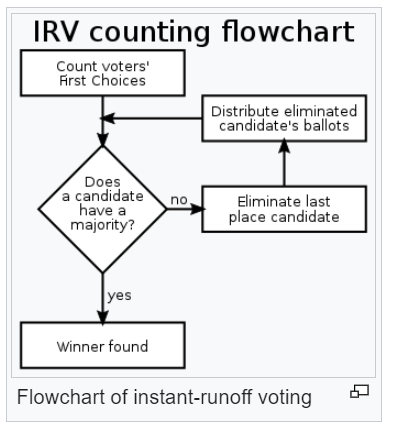